In [2]:
%matplotlib inline
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image
import cripser as cr

## set the following appropriately
PH_PROG = "./cubicalripser"     ## executable for Mac/Linux
#PH_PROG = "CubicalRipser.exe"   ## executable for Windows
IMG_DIR = "./lena/"  ## dir containing images; they must be of the same dimension
volfile = "vol.npy"  ## the image files will be combined and saved in this numpy file
ph_out = "PH.npy"    ## the computed persistent homology will be saved in this numpy file

In [24]:
## 3D example
# load image files from a dir and stack into a 3D array of type float64
input_files = IMG_DIR+"*.jpg"
files = sorted([f for f in glob.glob(input_files)])
img = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512, 9) float64 0.0 255.0


In [2]:
# make binary and apply distance transform
def dt(img,radius=15):
    from scipy.ndimage.morphology import distance_transform_edt
    from skimage.filters import threshold_otsu
#    bw_img = (img >= rank.otsu(img, disk(radius)))
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)
    return(dt_img)

In [5]:
# apply distance transform, if you want
#img = dt(img)

In [28]:
# compute PH with the python wrapper (takes time)
#!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))

elapsed_time:8.508371114730835 sec


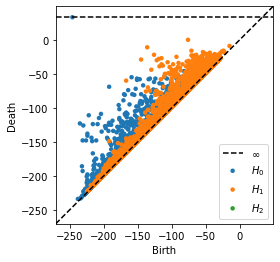

In [53]:
## plot persistent diagram using persim
#!pip install persim
%matplotlib inline
import persim
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [54]:
# load computed PH
print("#0-cycle {}, #1-cycle {}, #2-cycle {}".format(len(pds[0]),len(pds[1]),len(pds[2])))
# each line contains (dim,birth,death,x,y,z)
print(pds[0][:5])
print(pds[1][:5])
print(pds[2][:5])

#0-cycle 17479, #1-cycle 10384, #2-cycle 0
[[   0. -238. -234.  274.  116.    0.]
 [   0. -234. -233.  122.  414.    0.]
 [   0. -234. -233.  125.  415.    0.]
 [   0. -232. -231.  129.  416.    0.]
 [   0. -232. -230.  119.  411.    0.]]
[[  1. -15.  -9. 320. 180.   0.]
 [  1. -22. -19. 444. 365.   0.]
 [  1. -23. -17. 439. 363.   0.]
 [  1. -24. -16. 323. 179.   0.]
 [  1. -26. -17. 446. 365.   0.]]
[]


In [42]:
# compute the heatmap of cycles with specified birth-death properties
mx,my,mz=img.shape
selected_cycle = np.zeros(img.shape)
h=3
min_life = 10
max_life =255
min_birth = 0
max_birth = 255
dimension = 2
ppd = pds[dimension]
ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
ppd = ppd[min_birth < ppd[:,1]]
ppd = ppd[ppd[:,1] < max_birth]

print(ppd.shape)
for c in ppd:
    x,y,z=int(c[3]),int(c[4]),int(c[5])
#    selected_cycle[x,y,z] += 1
    selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += 1

print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))

(3645, 6)
0.0 7.0 671592.0


<IPython.core.display.Javascript object>


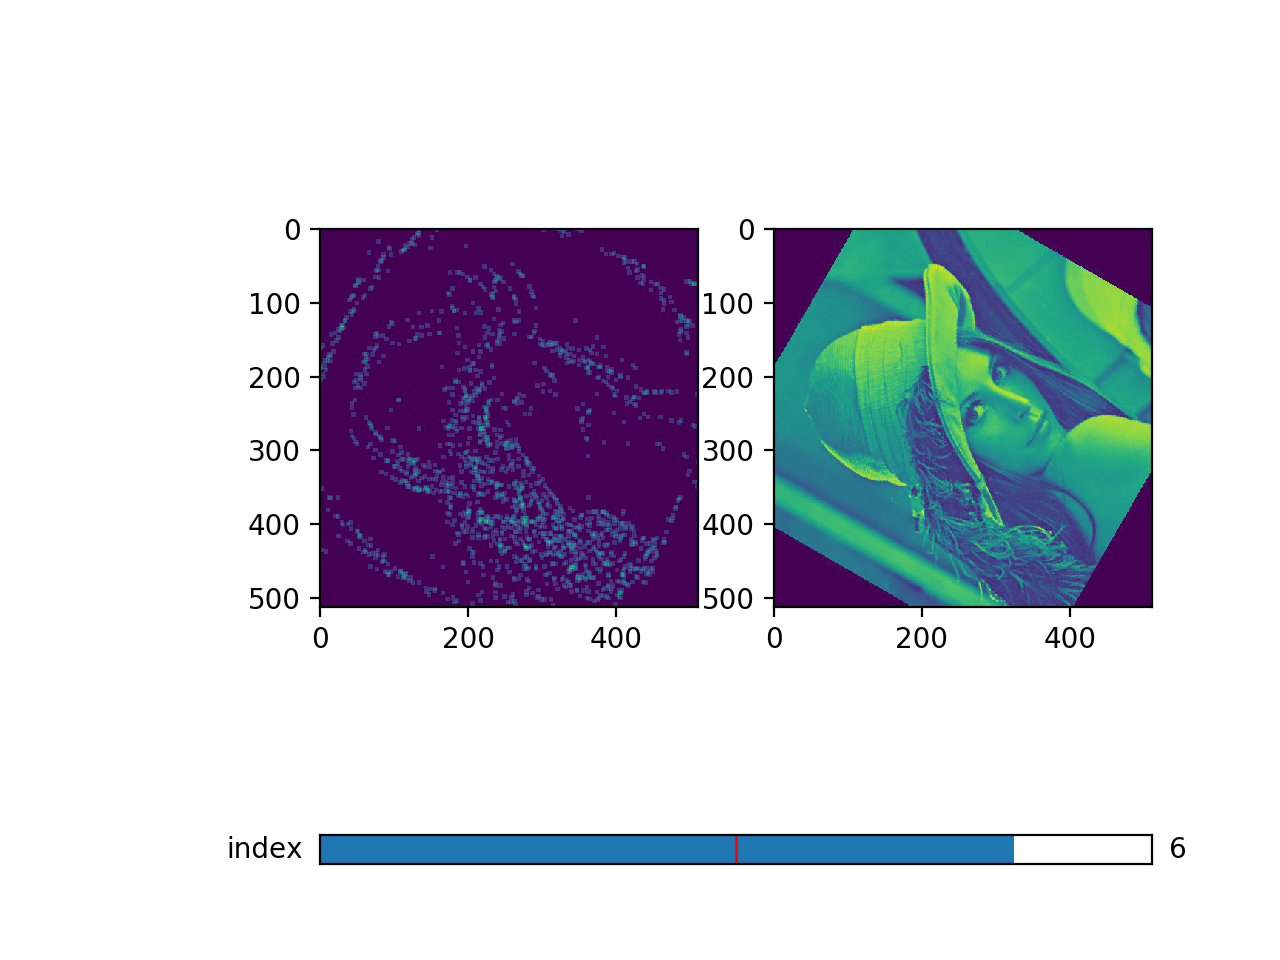

In [44]:
# Visualise the result
%matplotlib notebook
vol = selected_cycle
#vol = selected_cycle > 300
fig = plt.figure()
fig.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.subplot(121)
ind = vol.shape[2]//2
l = ax.imshow(vol[:,:,ind])
ax = plt.subplot(122)
l2 = ax.imshow(img[:,:,ind])
def update(val):
    ind = int(slider.val)
    l.set_data(vol[:,:,ind])
    l2.set_data(img[:,:,ind])
    fig.canvas.draw()        
ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax, 'index', 0, vol.shape[2] - 1, valinit=ind, valfmt='%i')
slider.on_changed(update)
plt.show()

In [2]:
## 2D example (usual image)
input_file = IMG_DIR+"lena00.jpg"
img = np.array(Image.open(input_file).convert('L'),dtype='f8')
print(img.shape, img.dtype, np.min(img),np.max(img))
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print(pd.shape)

(512, 512) float64 14.0 248.0


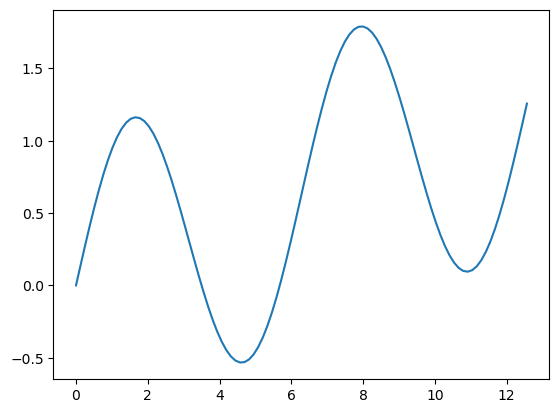

In [11]:
## 1D example (scalar timeseries)
x = np.linspace(0,4*np.pi,100)
img = np.sin(x)+0.1*x
plt.plot(x,img)
pd = cr.computePH(img)

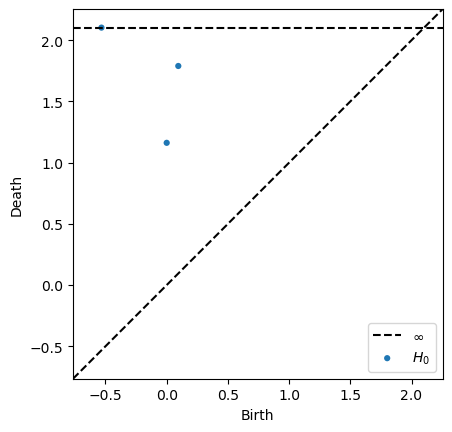

In [12]:
## plot persistence diagram
persim.plot_diagrams(pd[:,1:3])

In [5]:
## numpy array example
img = np.load("lena512.npy")
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print(pd.shape)

elapsed_time:0.24271416664123535 sec
(40720, 6)


In [29]:
# compute PH with the executable via shell (takes time)
np.save(volfile,img)
start = time.time()
result = subprocess.run(PH_PROG+' --output '+ph_out+' '+volfile, shell=True)
print(result)
print ("elapsed_time:{} sec".format(time.time() - start))
pd_c = np.load(ph_out)

CompletedProcess(args='./cubicalripser --output PH.npy vol.npy', returncode=0)
elapsed_time:10.034394979476929 sec


In [30]:
# the both method (python and executable) should give the same results
np.array_equal(pd,pd_c)

True